## Importing Dependencies

In [2]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=30

## Importing Dataset

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3653 files belonging to 6 classes.


In [5]:
class_names=dataset.class_names
class_names

['Malabar Spinach _Fungal Spot',
 'Malabar Spinach _Healthy',
 'Oriental Spinach_Healthy',
 'Oriental Spinach_Wormhole',
 'Water Spinach_Anthracnose spot',
 'Water Spinach_Healthy']

In [244]:
d1=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset2/Malabar Spinach _Fungal Spot",
    batch_size = 1
)
d2=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset2/Malabar Spinach _Healthy",
    batch_size = 1
)
d3=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset2/Oriental Spinach_Healthy",
    batch_size = 1
)
d4=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset2/Oriental Spinach_Wormhole",
    batch_size = 1
)
d5=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset2/Water Spinach_Anthracnose spot",
    batch_size = 1
)
d6=tf.keras.preprocessing.image_dataset_from_directory(
    "Pre_processed Dataset2/Water Spinach_Healthy",
    batch_size = 1
)

Found 487 files belonging to 1 classes.
Found 736 files belonging to 1 classes.
Found 682 files belonging to 1 classes.
Found 339 files belonging to 1 classes.
Found 779 files belonging to 1 classes.
Found 630 files belonging to 1 classes.


In [245]:
len(d1)

487

([<matplotlib.patches.Wedge at 0x2bcf68f7d30>,
 [Text(-0.44735270121537607, 1.004925649346909, 'Malabar Spinach _Fungal Spot'),
  Text(-1.0944836564593132, 0.11002511414878113, 'Malabar Spinach _Healthy'),
  Text(-0.479949009594071, -0.9897721698399439, 'Oriental Spinach_Healthy'),
  Text(0.4551174724185868, -1.0014330163816834, 'Oriental Spinach_Wormhole'),
  Text(1.0816822803970327, -0.19990858979812592, 'Water Spinach_Anthracnose spot'),
  Text(0.5672488970463133, 0.9424588525764619, 'Water Spinach_Healthy')],
 [Text(-0.24401056429929602, 0.5481412632801321, '13%'),
  Text(-0.5969910853414435, 0.06001369862660788, '20%'),
  Text(-0.26179036886949325, -0.5398757290036057, '19%'),
  Text(0.24824589404650185, -0.5462361907536454, '9%'),
  Text(0.5900085165801996, -0.10904104898079596, '21%'),
  Text(0.3094084892979891, 0.5140684650417064, '17%')])

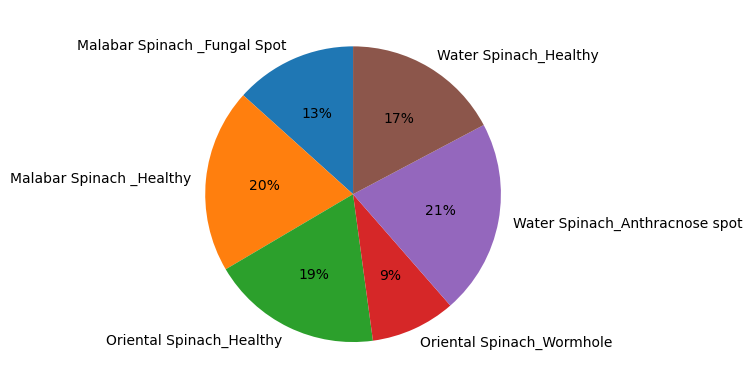

In [246]:
name = class_names
data = [len(d1), len(d2), len(d3), len(d4),len(d5), len(d6)]
plt.pie(data, labels=name, autopct='%0.f%%', startangle=90)

In [247]:
len(dataset)

115

In [248]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 4 1 1 1 2 4 4 5 5 4 0 0 4 4 2 4 4 5 3 5 1 4 1 4 2 5 5 4 0 1 5]


## Visualizing Dataset


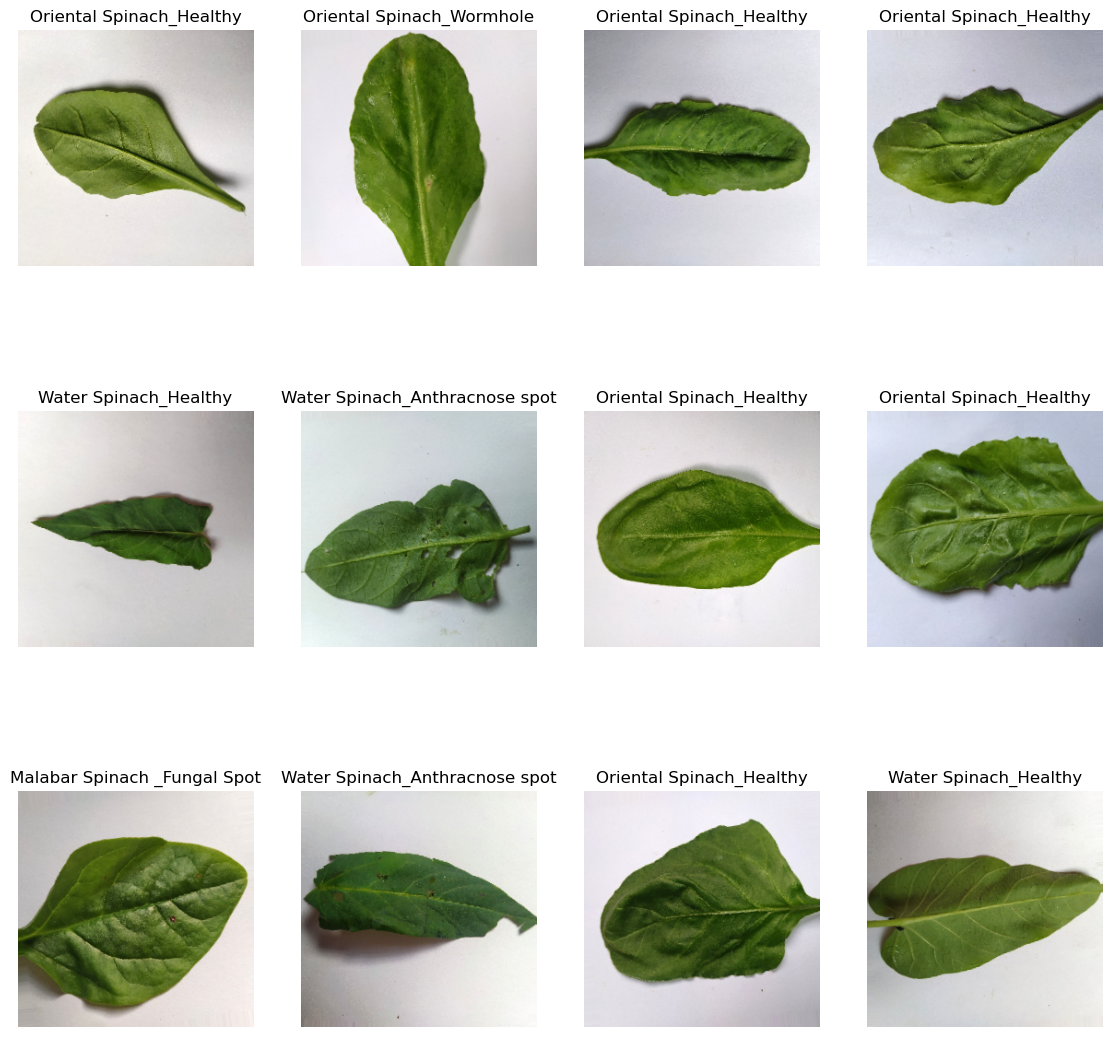

In [314]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
train_size = 0.8
len(dataset)*train_size

92.0

In [7]:
train_ds = dataset.take(92)
len(train_ds)

92

In [8]:
test_ds = dataset.skip(92)
len(test_ds)

23

In [9]:
val_size=0.1
len(dataset)*val_size

11.5

In [10]:
val_ds = test_ds.take(11)
len(val_ds)

11

In [11]:
test_ds = test_ds.skip(11)
len(test_ds)

12

In [12]:
#train data 80%, Test data 10%, Validation 10%
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

92

In [15]:
len(val_ds)

11

In [16]:
len(test_ds)

12

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model 

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We used a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

## CNN Architecture: Model 01

In [559]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model_01 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_01.build(input_shape=input_shape)

In [560]:
model_01.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_90 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (32, 60, 60, 128)       

In [561]:
model_01.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [562]:
history_01 = model_01.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
92/92 [==============================] - 278s 3s/step - loss: 1.4119 - accuracy: 0.4045 - val_loss: 1.1834 - val_accuracy: 0.4773
Epoch 2/30
92/92 [==============================] - 246s 3s/step - loss: 0.9860 - accuracy: 0.5807 - val_loss: 0.8619 - val_accuracy: 0.6392
Epoch 3/30
92/92 [==============================] - 248s 3s/step - loss: 0.7455 - accuracy: 0.6815 - val_loss: 0.6381 - val_accuracy: 0.7102
Epoch 4/30
92/92 [==============================] - 245s 3s/step - loss: 0.6564 - accuracy: 0.7268 - val_loss: 0.8074 - val_accuracy: 0.6335
Epoch 5/30
92/92 [==============================] - 240s 3s/step - loss: 0.5646 - accuracy: 0.7597 - val_loss: 0.7629 - val_accuracy: 0.7074
Epoch 6/30
92/92 [==============================] - 241s 3s/step - loss: 0.4844 - accuracy: 0.8046 - val_loss: 0.4629 - val_accuracy: 0.7841
Epoch 7/30
92/92 [==============================] - 241s 3s/step - loss: 0.4091 - accuracy: 0.8313 - val_loss: 0.3364 - val_accuracy: 0.8494
Epoch 8/30
92

In [649]:
scores_01 = model_01.evaluate(test_ds)

12/12 [==============================] - 10s 489ms/step - loss: 0.1162 - accuracy: 0.9740


## Plotting the Accuracy: Model 01

In [650]:
acc_01 = history_01.history['accuracy']
val_acc_01 = history_01.history['val_accuracy']

loss_01 = history_01.history['loss']
val_loss_01 = history_01.history['val_loss']

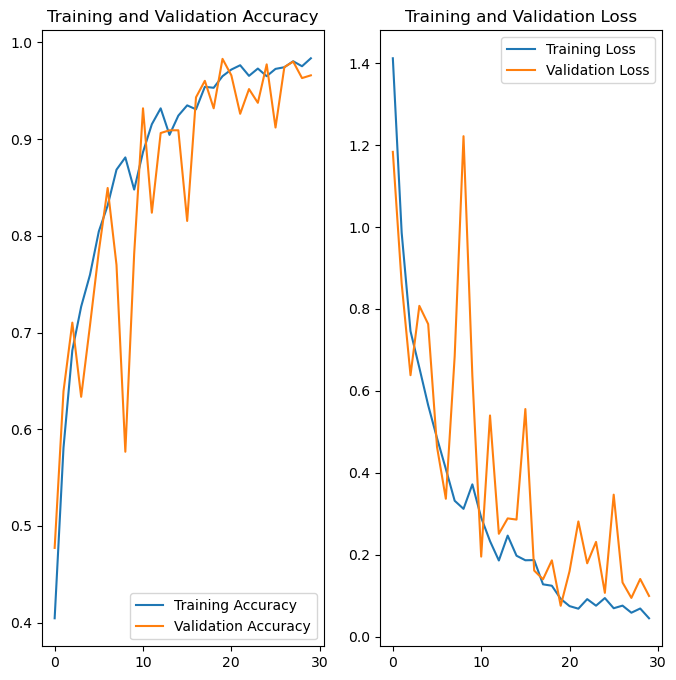

In [651]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_01, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_01, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_01, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_01, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [652]:
ccn_acc_01=scores_01[1]*100
print(f"Test Accuracy: ",ccn_acc_01)

Test Accuracy:  97.39583134651184


# CNN Architecture: Model 02

In [266]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model_02 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_02.build(input_shape=input_shape)

In [267]:
model_02.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (32, 252, 252, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 126, 126, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (32, 124, 124, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (32, 122, 122, 64)        36928     
                                                     

In [268]:
model_02.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [269]:
EPOCHS=30
history_02 = model_02.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
92/92 [==============================] - 677s 7s/step - loss: 1.4934 - accuracy: 0.3444 - val_loss: 1.1215 - val_accuracy: 0.4688
Epoch 2/30
92/92 [==============================] - 633s 7s/step - loss: 1.1062 - accuracy: 0.5149 - val_loss: 1.1082 - val_accuracy: 0.4972
Epoch 3/30
92/92 [==============================] - 629s 7s/step - loss: 1.0168 - accuracy: 0.5520 - val_loss: 0.9859 - val_accuracy: 0.5483
Epoch 4/30
92/92 [==============================] - 629s 7s/step - loss: 0.9795 - accuracy: 0.5713 - val_loss: 1.0331 - val_accuracy: 0.5540
Epoch 5/30
92/92 [==============================] - 635s 7s/step - loss: 0.8939 - accuracy: 0.5992 - val_loss: 0.9447 - val_accuracy: 0.5795
Epoch 6/30
92/92 [==============================] - 629s 7s/step - loss: 0.8301 - accuracy: 0.6338 - val_loss: 0.8780 - val_accuracy: 0.6165
Epoch 7/30
92/92 [==============================] - 632s 7s/step - loss: 0.7769 - accuracy: 0.6685 - val_loss: 0.8031 - val_accuracy: 0.6449
Epoch 8/30
92

In [280]:
scores_02 = model_02.evaluate(test_ds)

12/12 [==============================] - 31s 1s/step - loss: 0.4221 - accuracy: 0.8984


## Plotting the Accuracy of Model 02

In [87]:
acc_02 = history_02.history['accuracy']
val_acc_02= history_02.history['val_accuracy']

loss_02 = history_02.history['loss']
val_loss_02 = history_02.history['val_loss']

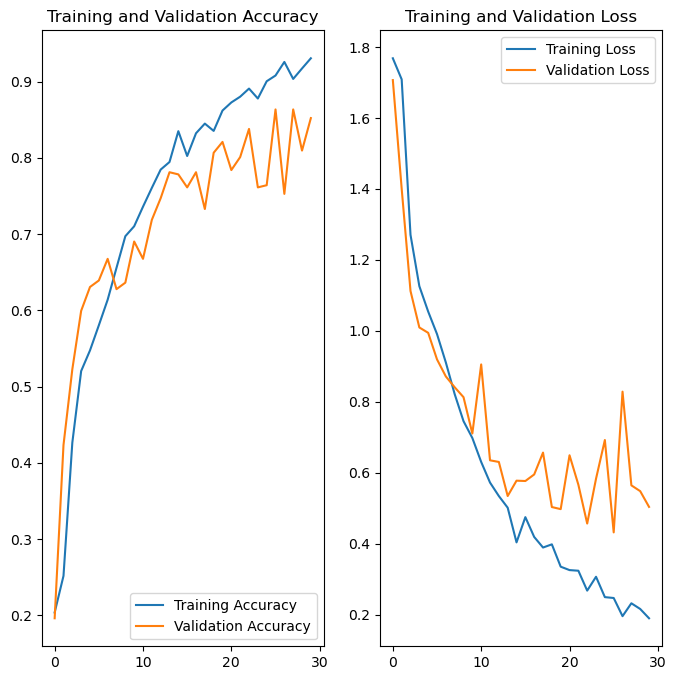

In [282]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_02, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_02, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_02, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_02, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [283]:
ccn_acc_02=scores_02[1]*100
print(f"Test Accuracy: ",ccn_acc_02)

Test Accuracy:  89.84375


## CNN Architecture: Model 03

Used 4 layers of double Conv2d and 4 Pooling layers with Dropout Layer.

The main difference between single Conv2d and double Conv2d has more flexibility in expressing non-linear transformations without losing information. Maxpool removes information from the signal, dropout forces distributed representation, thus both effectively make it harder to propagate information.

If a highly non-linear transformation has to be applied on raw data, stacking multiple Convs with Relu will make it easier to learn. Also model with 3 max poolings with model with only 2, consequently the second one will potentially lose less information. Another thing is it has way bigger fully connected bits at the end, while the first one is tiny with 0.5 dropout.

This works much better than the one above in that it achieved better accuracy, lower error rate, and took many more epochs before overfitting the training data.

In [149]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model_03 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.50),
    
    layers.Dense(n_classes, activation='softmax'),
])

model_03.build(input_shape=input_shape)

In [150]:
model_03.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_64 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 conv2d_65 (Conv2D)          (32, 252, 252, 32)        9248      
                                                                 
 max_pooling2d_48 (MaxPoolin  (32, 126, 126, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (32, 126, 126, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (32, 124, 124, 64)        18496     
                                                     

In [151]:
model_03.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [154]:
history_03 = model_03.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
92/92 [==============================] - 655s 7s/step - loss: 1.6914 - accuracy: 0.2622 - val_loss: 1.5302 - val_accuracy: 0.3097
Epoch 2/25
92/92 [==============================] - 643s 7s/step - loss: 1.2898 - accuracy: 0.4596 - val_loss: 1.3554 - val_accuracy: 0.4233
Epoch 3/25
92/92 [==============================] - 647s 7s/step - loss: 1.1288 - accuracy: 0.5214 - val_loss: 1.1510 - val_accuracy: 0.5085
Epoch 4/25
92/92 [==============================] - 647s 7s/step - loss: 1.0792 - accuracy: 0.5462 - val_loss: 1.0601 - val_accuracy: 0.5426
Epoch 5/25
92/92 [==============================] - 639s 7s/step - loss: 0.9809 - accuracy: 0.5863 - val_loss: 0.9428 - val_accuracy: 0.6023
Epoch 6/25
92/92 [==============================] - 649s 7s/step - loss: 0.9286 - accuracy: 0.6012 - val_loss: 0.8550 - val_accuracy: 0.6449
Epoch 7/25
92/92 [==============================] - 641s 7s/step - loss: 0.8766 - accuracy: 0.6321 - val_loss: 0.8161 - val_accuracy: 0.6392
Epoch 8/25
92

In [155]:
scores_03 = model_03.evaluate(test_ds) 

12/12 [==============================] - 19s 2s/step - loss: 0.5120 - accuracy: 0.8099


## Plotting the Accuracy of Model 03

In [156]:
acc_03 = history_03.history['accuracy']
val_acc_03= history_03.history['val_accuracy']

loss_03 = history_03.history['loss']
val_loss_03 = history_03.history['val_loss']

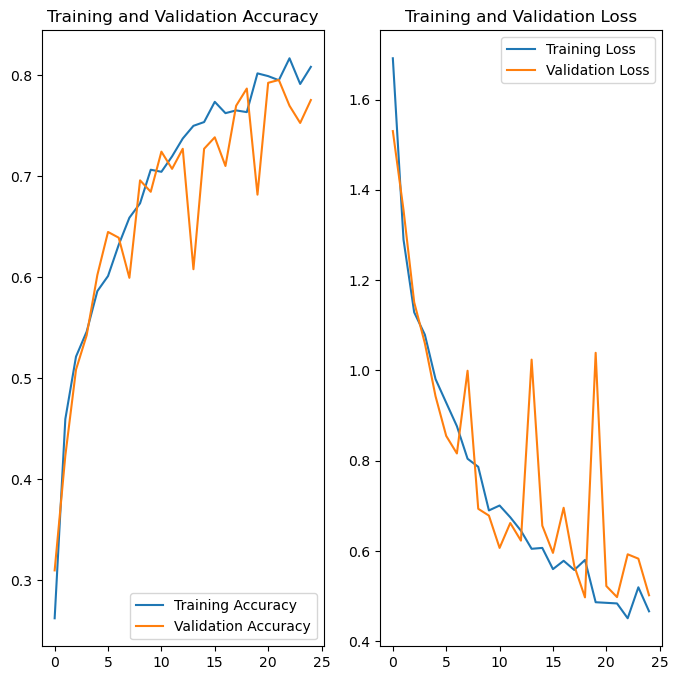

In [157]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc_03, label='Training Accuracy')
plt.plot(range(25), val_acc_03, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss_03, label='Training Loss')
plt.plot(range(25), val_loss_03, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [158]:
ccn_acc_03=scores_03[1]*100
print(f"Test Accuracy: ",ccn_acc_03)

Test Accuracy:  80.98958134651184


## Resnet50 - Model: 04

In [21]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3),classes=6)

In [22]:
#Model building
base_model_tf.trainable=False

pt=Input(shape=(256,256,3))
func=tf.cast(pt,tf.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_04=Model(inputs=pt,outputs=model_resnet)
model_04.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [23]:
model_04.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
history_04 = model_04.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
92/92 [==============================] - 403s 4s/step - loss: 0.6710 - accuracy: 0.7604 - val_loss: 0.2520 - val_accuracy: 0.9148
Epoch 2/20
92/92 [==============================] - 375s 4s/step - loss: 0.2069 - accuracy: 0.9304 - val_loss: 0.1780 - val_accuracy: 0.9403
Epoch 3/20
92/92 [==============================] - 370s 4s/step - loss: 0.1297 - accuracy: 0.9592 - val_loss: 0.1692 - val_accuracy: 0.9347
Epoch 4/20
92/92 [==============================] - 366s 4s/step - loss: 0.0966 - accuracy: 0.9681 - val_loss: 0.0944 - val_accuracy: 0.9744
Epoch 5/20
92/92 [==============================] - 360s 4s/step - loss: 0.1170 - accuracy: 0.9578 - val_loss: 0.0950 - val_accuracy: 0.9744
Epoch 6/20
92/92 [==============================] - 363s 4s/step - loss: 0.0637 - accuracy: 0.9794 - val_loss: 0.0885 - val_accuracy: 0.9744
Epoch 7/20
92/92 [==============================] - 361s 4s/step - loss: 0.0696 - accuracy: 0.9750 - val_loss: 0.0735 - val_accuracy: 0.9801
Epoch 8/20
92

In [25]:
scores_04 = model_04.evaluate(test_ds) 

12/12 [==============================] - 60s 4s/step - loss: 0.0691 - accuracy: 0.9661


## Plotting the Accuracy of Model 04

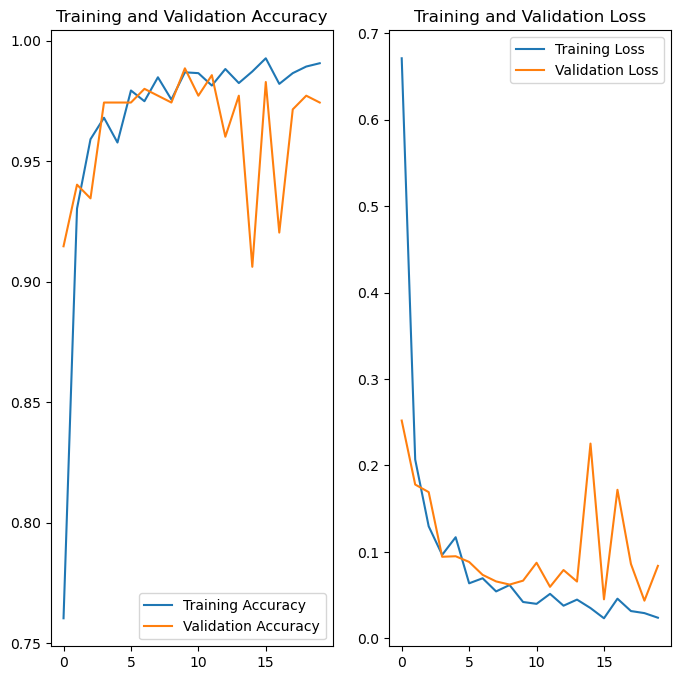

In [26]:
acc_04 = history_04.history['accuracy']
val_acc_04= history_04.history['val_accuracy']

loss_04 = history_04.history['loss']
val_loss_04 = history_04.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc_04, label='Training Accuracy')
plt.plot(range(20), val_acc_04, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss_04, label='Training Loss')
plt.plot(range(20), val_loss_04, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
res_acc_04=scores_04[1]*100
print(f"Test Accuracy: ",res_acc_04)

Test Accuracy:  96.61458134651184


## MobileNetV2 Model 05

In [ ]:
target_size = (IMAGE_SIZE, IMAGE_SIZE)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
grid_shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3)

In [ ]:
base2_model_tf=keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(256,256,3))
base2_model_tf.trainable = False

In [ ]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = base2_model_tf(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(dataset), activation="softmax")(x)

# Combine the model
model_05 = Model(inputs=inputs, outputs=x)

model_05.summary()

In [170]:
model_05.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [171]:
history_05 = model_05.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
92/92 [==============================] - 107s 1s/step - loss: 1.6456 - accuracy: 0.3835 - val_loss: 1.1704 - val_accuracy: 0.5369
Epoch 2/25
92/92 [==============================] - 91s 987ms/step - loss: 1.0682 - accuracy: 0.5839 - val_loss: 1.0223 - val_accuracy: 0.6307
Epoch 3/25
92/92 [==============================] - 92s 999ms/step - loss: 0.9284 - accuracy: 0.6382 - val_loss: 1.0045 - val_accuracy: 0.6278
Epoch 4/25
92/92 [==============================] - 96s 1s/step - loss: 0.8599 - accuracy: 0.6712 - val_loss: 0.9361 - val_accuracy: 0.6222
Epoch 5/25
92/92 [==============================] - 91s 994ms/step - loss: 0.8030 - accuracy: 0.6780 - val_loss: 0.8494 - val_accuracy: 0.6847
Epoch 6/25
92/92 [==============================] - 92s 998ms/step - loss: 0.7723 - accuracy: 0.6800 - val_loss: 0.8860 - val_accuracy: 0.6392
Epoch 7/25
92/92 [==============================] - 97s 1s/step - loss: 0.7194 - accuracy: 0.7184 - val_loss: 0.8410 - val_accuracy: 0.6676
Epoch 8

In [172]:
scores_05 = model_05.evaluate(test_ds)

12/12 [==============================] - 10s 869ms/step - loss: 0.7511 - accuracy: 0.6901


## Plotting the Accuracy of Model 05

In [184]:
acc_05 = history_05.history['accuracy']
val_acc_05 = history_05.history['val_accuracy']

loss_05 = history_05.history['loss']
val_loss_05 = history_05.history['val_loss']

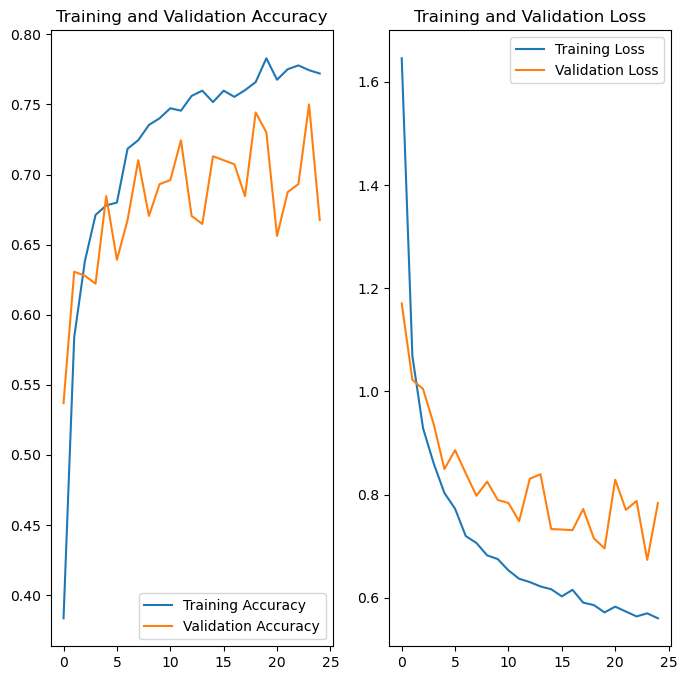

In [185]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc_05, label='Training Accuracy')
plt.plot(range(25), val_acc_05, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss_05, label='Training Loss')
plt.plot(range(25), val_loss_05, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [186]:
mob_acc_05=scores_05[1]*100
print(f"Test Accuracy: ",mob_acc_05)

Test Accuracy:  69.01041865348816


## EfficientNetB4 Model: 06

In [25]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

In [26]:
efficientNetB4_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [33]:
efficientNetB4_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="input_layer")
x = data_augmentation(inputs) 

x = efficientNetB4_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)



outputs = layers.Dense(6, activation="softmax", name="output_layer")(x)
model_06 = tf.keras.Model(inputs, outputs)

In [34]:
model_06.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_avg_pool_layer (Glob  (None, 1792)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 6)                 10758     
                                                                 
Total params: 17,684,581
Trainable params: 10,758
Non-trainable params: 17,673,823
__________________________________________

In [35]:
model_06.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
history_06 = model_06.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
92/92 [==============================] - 558s 6s/step - loss: 1.5669 - accuracy: 0.4556 - val_loss: 1.4279 - val_accuracy: 0.5398
Epoch 2/25
92/92 [==============================] - 494s 5s/step - loss: 1.2923 - accuracy: 0.6438 - val_loss: 1.2189 - val_accuracy: 0.6705
Epoch 3/25
92/92 [==============================] - 477s 5s/step - loss: 1.1191 - accuracy: 0.7151 - val_loss: 1.0746 - val_accuracy: 0.6591
Epoch 4/25
92/92 [==============================] - 358s 4s/step - loss: 0.9916 - accuracy: 0.7525 - val_loss: 0.9751 - val_accuracy: 0.7131
Epoch 5/25
92/92 [==============================] - 356s 4s/step - loss: 0.8971 - accuracy: 0.7803 - val_loss: 0.8973 - val_accuracy: 0.7244
Epoch 6/25
92/92 [==============================] - 356s 4s/step - loss: 0.8234 - accuracy: 0.7895 - val_loss: 0.8277 - val_accuracy: 0.7727
Epoch 7/25
92/92 [==============================] - 356s 4s/step - loss: 0.7651 - accuracy: 0.8046 - val_loss: 0.7824 - val_accuracy: 0.7869
Epoch 8/25
92

In [37]:
scores_06 = model_06.evaluate(test_ds)

12/12 [==============================] - 59s 4s/step - loss: 0.4232 - accuracy: 0.8802


## Plotting the Accuracy of Model 06

In [ ]:
acc_06 = history_06.history['accuracy']
val_acc_06= history_06.history['val_accuracy']

loss_06 = history_06.history['loss']
val_loss_06 = history_06.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc_06, label='Training Accuracy')
plt.plot(range(25), val_acc_06, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss_06, label='Training Loss')
plt.plot(range(25), val_loss_06, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
inc_acc_06=scores_06[1]*100
print(f"Test Accuracy: ",inc_acc_06)

## Accuracy Comparison Plot Between Proposed And Transfer Learning Models

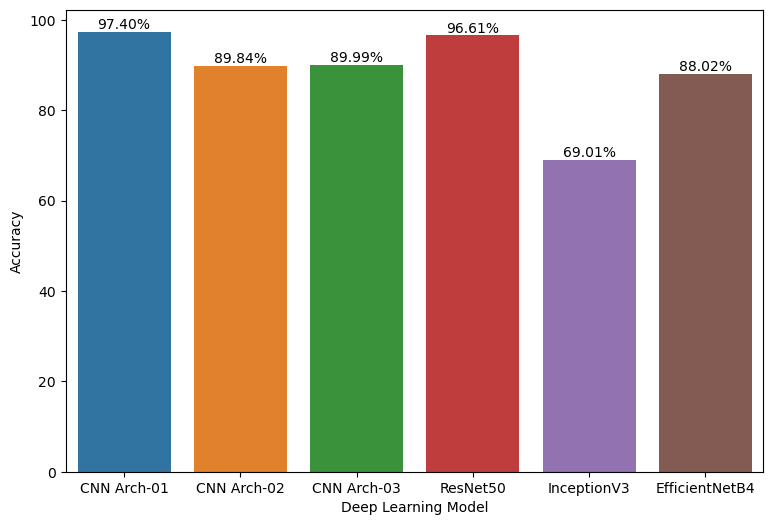

In [28]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=
{'Deep Learning Model':['CNN Arch-01','CNN Arch-02','CNN Arch-03','ResNet50','InceptionV3','EfficientNetB4'],
'Accuracy':[97.40, 89.84 , 89.99 , 96.61, 69.01, 88.02]})

plt.figure(figsize=(9,6))
p = sns.barplot(x='Deep Learning Model', y='Accuracy',data=df)

for i in p.containers:
    labels = [f'{v.get_height():0.02f}%' for v in i]
    p.bar_label(i, labels=labels)

## Run prediction with CNN ARCH 01 on a sample image

first image to predict
actual label: Water Spinach_Healthy
1/1 [==============================] - 1s 780ms/step
predicted label: Water Spinach_Healthy


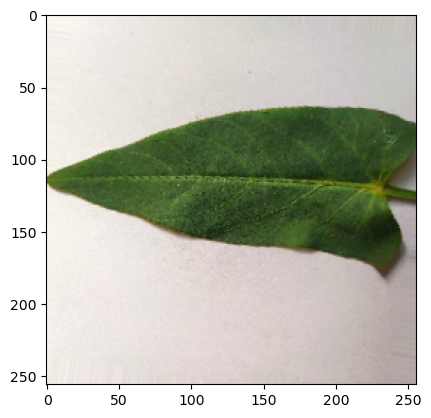

In [672]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_01.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Inference on few sample images

In [673]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_01.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 72ms/step


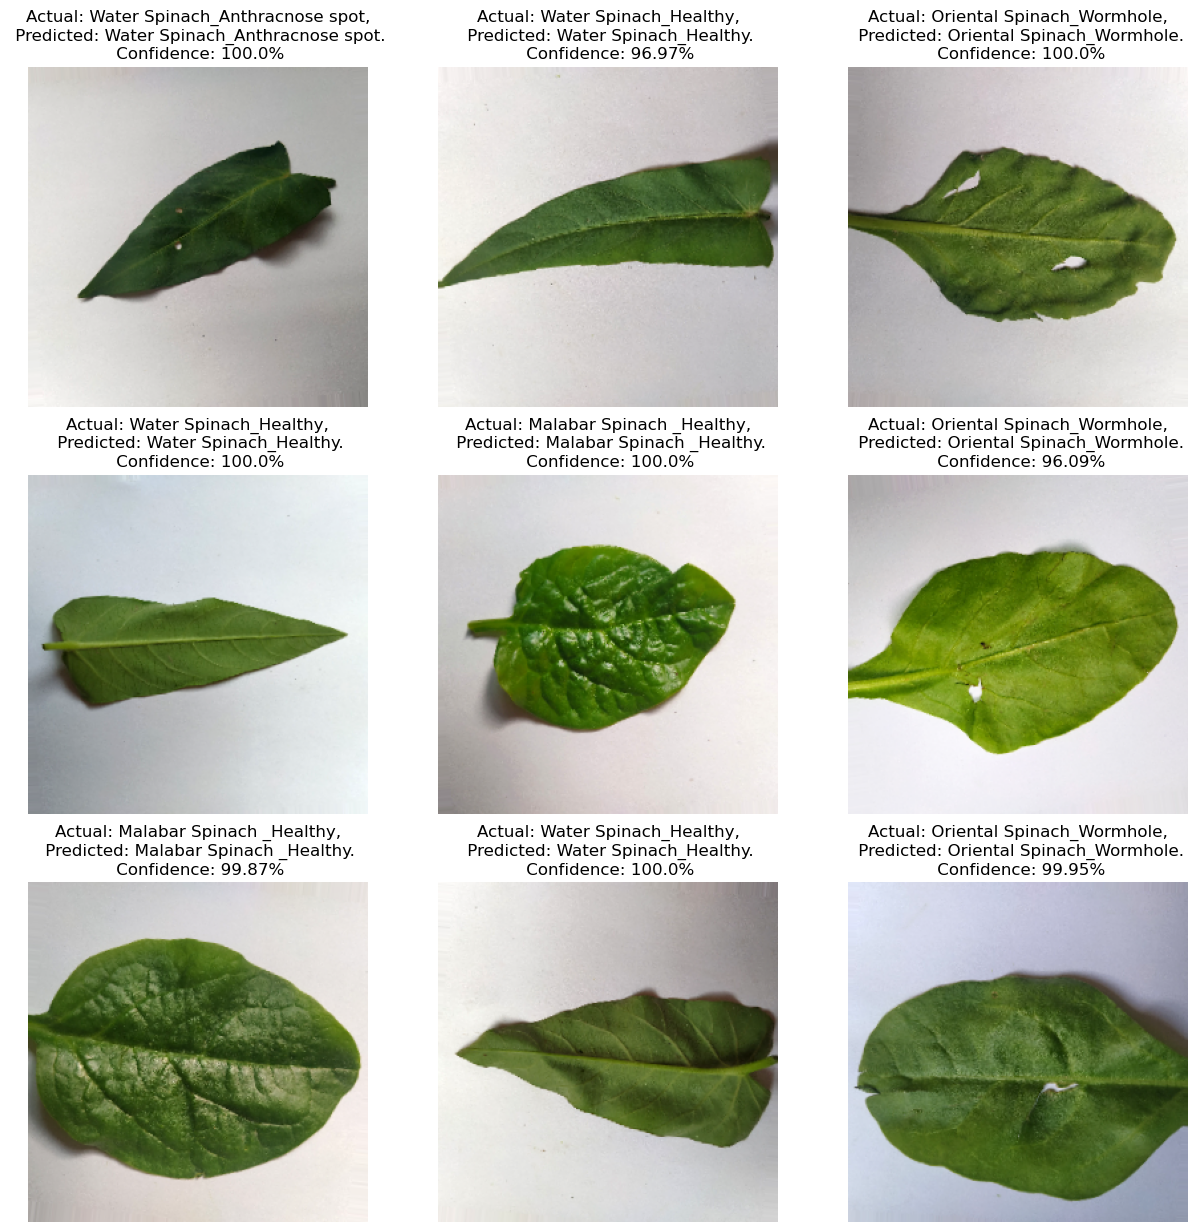

In [674]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_01, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")